# Text Classification
Can we figure out of a set of lines is from Moby Dick vs. Romeo and Juliet?

Starting with "Romeo and Juliet" and "Moby Dick" split into 5 line chunks, using scikit-learn, we will
1. Split the data into a training set (80%) and a test set (20%)
2. Create "features" of word vectors (count words or word phrases in the two texts) using TfidfVectorizer
3. Determine which features best differentiate between the two books using SelectKBest
4. Train a stochastic gradient descent classifier (SGDClassifier) 
5. Test the performance of the classifier against the test set 

Most of this code is modified from "Hands on Machine Learning with Scikit" by Aurélien Géron

## Splitting Moby Dick and Romeo and Juliet

``` bash
# Word wrap at 80 characters
fold -w 80 -s moby_dick.txt

# Now split the text every 5 lines, and prefix with a label
cd book_data
split -d -l 5 ../romeo_juliet.txt RJ_
split -d -l 5 ../moby_dick.txt MD_
```

## Key Imports

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

## Import our Labeled Text into a DataFrame

In [2]:
# First, let's import the full collection of labeled texts
#
# All of the text is in "book_data" and begins with a label "MD_" for "Moby Dick" 
# or "RJ_" for Romeo and Juliet
#

filenames = []
texts = []
labels = []
path = "book_data"
# First let's
for file in os.listdir(path):
    if not file.startswith('.'):
        filenames.append(file)
        labels.append(file.split('_')[0])
        with open(os.path.join(path,file), 'r') as f:
            texts.append(f.read())

# We read the text and insert it into a pandas dataframe. Sklearn uses dataframes
# because it is a table class with nice analysis methods
labeled_data = pd.DataFrame()
labeled_data['filename'] = filenames
labeled_data['text'] = texts
labeled_data['label'] = labels

# Display the first 6 rows to show that we successfully read it
labeled_data.head(6)

,filename,text,label
0,MD_990986,"“Cook,” said Stubb, rapidly lifting a rather r...",MD
1,MD_991098,"\nA short space elapsed, and up into this nois...",MD
2,MD_990803,"said humorous Stubb one day, “he can never be ...",MD
3,MD_9128,and portion off their nieces with a few porpoi...,MD
4,MD_991281,as ordinary fish possess what is called a swim...,MD
5,RJ_9286,"JULIET\nNow, good sweet nurse,--O Lord, why lo...",RJ


## Split our Data into Training and Test Sets
It is very important to set aside part of our available data into a "test set" that is not used to train the model.
Why? Because it is very easy to "overfit" a model with our training data. Overfitting creates a complex model that
works wondefully with the training data, but does not generalize well to other data. By setting aside a test set 
until the very end, we ensure that our model is better suited to classify data we haven't encountered before.

In [3]:
# Now let's split our data into a training set and test set
training_data, test_data = train_test_split(labeled_data, test_size=0.2, stratify=labeled_data['label'])

In [4]:
# Make sure our data is split 80/20 and that we have examples of both labels in our sets
training_data['label'].value_counts()


MD    3079
RJ     691
Name: label, dtype: int64

In [5]:
test_data['label'].value_counts()

MD    770
RJ    173
Name: label, dtype: int64

## Create a Classifier Pipeline and Fit Against Test Data
Note: There are many "hyperparameters" that can be used to improve the quality of our classifier.
For this demo, we're picking simple options (leaving most at the defaults). We will explore
improving the options in another notebook.

In [6]:
# Now let's make a classifier with 3 steps:
#   1. Vectorize the text as individual words with English stop words
#   2. Select the best K=100 features
#   3. SGDClassification
estimator = Pipeline([('vectorizer', TfidfVectorizer(stop_words='english')),
                      ('select', SelectKBest(k=100)),
                      ('classifier', SGDClassifier())])

In [7]:
# This powerful line will initialize the vectorizer, select the k=10 best features
# and find the weights of the features to best separate (classify) the two
# classes of book segments
estimator.fit(training_data['text'],training_data['label']);

## Check the Accuracy of the Classifier Against the Training Data

Here we are going to make predicitions using our classifier against our training set. This should be
pretty accurate if we have enough quality features. Sklearn provides a nice report to tell us if our
classification performs well, but it requires some definitions:

"precision" is the ratio of true positive predictions over all positive predictions 

    precision = TruePos / (TruePos + FalsePos)
    
"recall" is the ratio of true positive predictions over all actual positive items

    recall = TruePos / (TruePos + FalseNeg)
  
The f1-score is the harmonic mean of precision and recall 

    f1-score = ( 2 / (1/recall) + (1/precision) ) = 2 * (precision * recall) / (precision + recall)
             = TruePos / (TrusPos + ((FalsNeg + FalsePos)/2)))

In [8]:
pred = estimator.predict(training_data['text'])

In [9]:
print(metrics.classification_report(training_data['label'],pred))

              precision    recall  f1-score   support

          MD       0.97      1.00      0.98      3079
          RJ       0.99      0.86      0.92       691

    accuracy                           0.97      3770
   macro avg       0.98      0.93      0.95      3770
weighted avg       0.97      0.97      0.97      3770



## Check the Accuracy of the Classifier Against the Test Data

And now for the moment of truth: Does our classifier do well against the test data we set aside from the beginning?


In [10]:
pred = estimator.predict(test_data['text'])

In [11]:
print(metrics.classification_report(test_data['label'],pred))

              precision    recall  f1-score   support

          MD       0.96      1.00      0.98       770
          RJ       0.99      0.83      0.91       173

    accuracy                           0.97       943
   macro avg       0.98      0.92      0.94       943
weighted avg       0.97      0.97      0.97       943



## Plot Precision and Recall Vs. the Threshold
The classifier creates a score based upon coefficients it calculated for each feature. If the total score for a piece of text is over a threshold (designed to be "0"), then that text is determined to be in the positive class ("Romeo and Juliet" in our example).

But the threshold is a natural tradeoff between precision and recall. If we set our threshold lower, we'd catch more false negatives (improving recall) but also let more false positives in (hurting precision). Similarly, if we increase our threshold, we'd remove false positives (improving precision) but create more false negatives (hurting recall).  We can plot this relationship between recall and the threshold and between precision and the threshold:

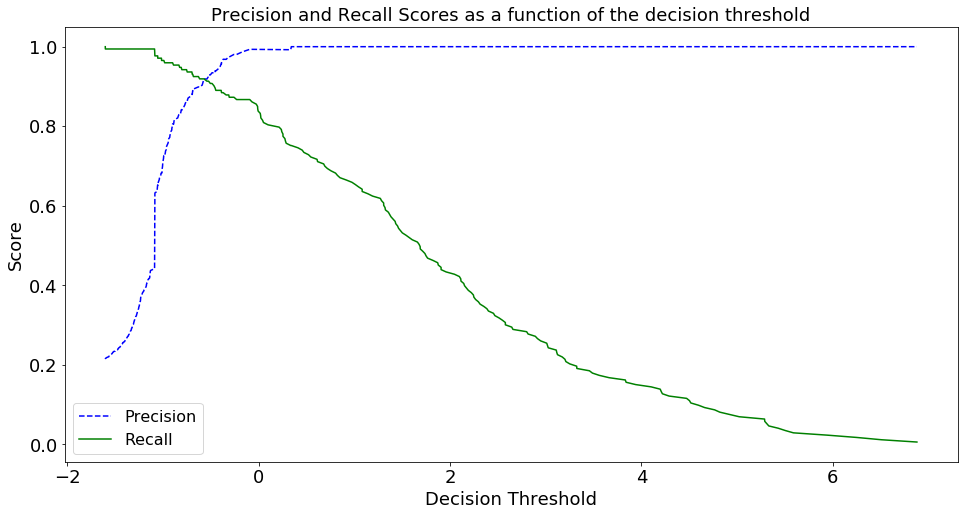

In [12]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    font = {'family' : 'Dejavu Sans',
            'weight' : 'medium',
            'size'   : 18}

    plt.rc('font', **font)
    
    plt.figure(figsize=(16, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold",fontdict=font)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score",fontdict=font)
    plt.xlabel("Decision Threshold",fontdict=font)
    plt.legend(loc='best',fontsize=16)
    
    
pos_label = 'RJ'
# Calculate a "score" (a decision threshold)
try:
    # Get the index of the class that is "Romeo and Juliet"
    positive_class_col = list(estimator.classes_).index(pos_label)
    scores = estimator.predict_proba(test_data['text'])[:, positive_class_col]
except AttributeError:
    scores = estimator.decision_function(test_data['text'])

precisions, recalls, thresholds = metrics.precision_recall_curve(test_data['label'], scores, pos_label=pos_label)    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

## Let's use our estimator to predict (and display the score) of some phrases!

In [13]:
estimator.predict(["And yet I would it were to give again."])[0]

'MD'

In [14]:
estimator.decision_function(["And yet I would it were to give again."])[0]

-1.086292334103678

In [15]:
estimator.predict(["I might proceed with several more examples, one way or another known to me, of the great power and malice at times of the sperm whale. In more than one instance, he has been known, not only to chase the assailing boats back to their ships, but to pursue the ship itself, and long withstand all the lances hurled at him from its decks."])[0]

'MD'

In [16]:
estimator.predict(["Wouldst thou withdraw it? for what purpose, love?"])[0]

'RJ'

In [17]:
estimator.decision_function(["Wouldst thou withdraw it? for what purpose, love?"])[0]

0.8773460816346861

In [18]:
estimator.decision_function(["Is this sentence more like Romeo and Juliet or like Moby Dick?"])[0]

3.1484447051426407

In [19]:
estimator.predict(["Is this sentence more like Shakespeare or like Moby Dick?"])[0]

'MD'

In [20]:
estimator.decision_function(["Is this sentence more like Shakespeare or like Moby Dick?"])[0]

-1.295016499088502

## What are the chosen features and their coefficients?
With a little work, we can ask the pipeline what features it chose and what coefficients it assigned to those features. Intuitively, a positive coefficient means that the word belongs to Romeo and Juliet. A negative coefficient means that the word belongs to Moby Dick.

In [21]:
features = estimator.named_steps['vectorizer'].get_feature_names()
mask = estimator.named_steps['select'].get_support()
new_features = [ feature for bool, feature in zip (mask, features) if bool ]
nf = pd.DataFrame({'features': new_features, 'coef': estimator.named_steps['classifier'].coef_[0] })
nf.sort_values(['coef'], ascending=0)

,features,coef
66,romeo,8.542598
38,juliet,6.390476
58,nurse,5.508022
46,love,5.464828
89,tybalt,5.381305
...,...,...
80,stubb,-1.658741
99,ye,-1.849700
7,captain,-2.219872
95,whale,-2.223837
